## SVHN_1_Explore


Notebook 1: Explore the dataset structure, and test matlab-to-python reading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import os
import PIL as pil
import itertools

In [3]:
os.listdir('data')

['extra_32x32.mat', 'test_32x32.mat', 'train_32x32.mat']

In [4]:
training_data = scipy.io.loadmat(file_name='data/train_32x32.mat')
print(type(training_data), len(training_data))
print(training_data.keys())
print(training_data['X'].shape)
print(training_data['y'].shape)
X = training_data['X']
y = training_data['y'] 

<class 'dict'> 5
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(32, 32, 3, 73257)
(73257, 1)


Data is imported as dict, with three less relevant keys. Separating into X, y, suitable for initial data load is simple.

Quick visual check to see what things are like:

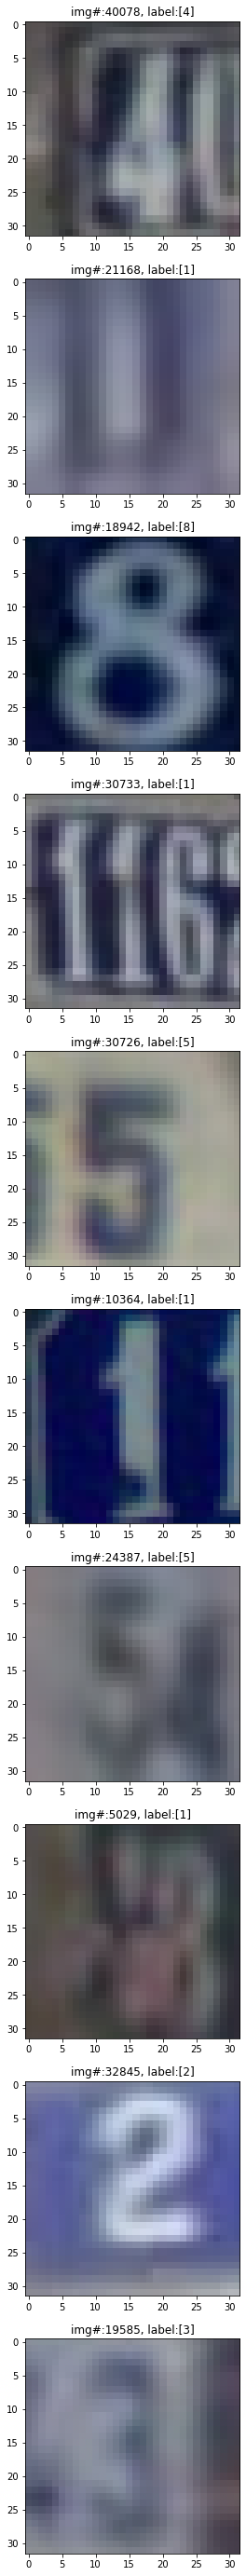

In [6]:
fig = plt.figure(figsize=(5,50))
for i in range(0,10):
    plt.subplot(10,1,i+1)
    image_number = np.random.randint(low=0,high=(X.shape[-1]-1))
    plt.imshow(X=X[:,:,:,image_number])
    plt.title(f'img#:{image_number}, label:{y[image_number]}')

In [7]:
def grouper(iterable, batch_size, fillvalue=0):
    "Collect data into non-overlapping fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, fillvalue='x') --> ABC DEF Gxx
    args = [iter(iterable)] * batch_size
    
    return itertools.zip_longest(*args, fillvalue=fillvalue)

In [8]:
run_sheet=list(range(0,20))
print(run_sheet)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [9]:
run_sheet = list(range(0,20))
np.random.shuffle(run_sheet)
print(run_sheet)

[2, 7, 5, 1, 14, 6, 4, 0, 19, 15, 17, 8, 13, 11, 12, 9, 16, 10, 18, 3]


In [10]:
run_sheet = grouper(run_sheet,7,0)
run_sheet = list(run_sheet)

print(run_sheet)

[(2, 7, 5, 1, 14, 6, 4), (0, 19, 15, 17, 8, 13, 11), (12, 9, 16, 10, 18, 3, 0)]


In [11]:
for group in run_sheet:
    print(group)
    print(group[5])

(2, 7, 5, 1, 14, 6, 4)
6
(0, 19, 15, 17, 8, 13, 11)
13
(12, 9, 16, 10, 18, 3, 0)
3


In [12]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [13]:
max(3,5)

5

In [70]:
from doctest import OutputChecker
import numpy as np
import pandas as pd
import PIL as pil
import math

def rotate(X, max_rotation_angle_degrees=15,nearest_neighbour = True):
    

    # rotate from centre, find new location pixel by pixel.
    # then clean it up a bit by doing 8-conn smoothing
    img_x, img_y, img_c = X.shape

    max_side_length = int(np.sqrt(img_x**2 + img_y**2)) #45 degrees is bad
    # pre-create output image with max possible size, even tho we crop later
    rotated = np.zeros(shape=(max_side_length, max_side_length, img_c))
    rot_x, rot_y, _ = rotated.shape

    #centre coords, rotate around these
    cx = rot_x//2
    cy = rot_y//2
    
    #with this randomly chosen angle within the bounds
    angle_degrees=np.random.choice([-1,1])*np.random.random(1)*max_rotation_angle_degrees
    print(f'random angle was: {angle_degrees}')
    angle_rad = math.radians(angle_degrees)

    # roll through the output-size image, for each pixel, try to find valid one in input image
    for j in range(0, rot_y):
        for i in range(0, rot_x):
            # apply rotation
            x = (i-cx)*np.cos(angle_rad) - (j-cy)*np.sin(angle_rad)
            y = (i-cx)*np.sin(angle_rad) + (j-cy)*np.cos(angle_rad)

            # shift
            x += cx
            y += cy

            # Nearest Neighbour
            if nearest_neighbour:
                x = round(x)
                y = round(y)

                if (x>=0 and x<img_x) and (y>=0 and y<img_y):
                    rotated[i,j,:] = X[x,y,:]
            else:
                # quick-interp
                x_low = int(np.floor(x))
                x_high = int(np.ceil(x))
                y_low = int(np.floor(y))
                y_high = int(np.ceil(y))
                
                if x_low == x_high:
                    x_high +=1
                if y_low == y_high:
                    y_high +=1

                if (x_low>=0 and x_high<img_x) and (y_low>=0 and y_high<img_y):
                    d_lh = np.sqrt((x_low-x_high)**2 + (y_low-y_high)**2)
                    d_ln = np.sqrt((x_low-x)**2 + (y_low-y)**2)
                    d_nh = d_lh - d_ln
                    
                    #1e-6 to prevent true divide error
                    rotated[i,j,:] = (X[x_low,y_low,:]*d_ln + X[x_high,y_high,:]*d_nh) / d_lh
        
    #crop output
    output = rotated[0:img_x, 0:img_y, :]

    return output

def gaussian_blur(X, sigma=0.05, width=5):
    # apply gaussian blur
    a = np.linspace(-np.floor(width/2), np.floor(width/2), width) #linear space from [-width/2,width/2]
    g = (1/np.sqrt(2*np.pi)) * np.exp(0.5*np.square(a))/np.square(sigma) #gaussian function over axis a
    kernel = np.outer(g,g) # make it a square
    kernel = kernel / np.sum(kernel) #normalize
    
    output = conv2d(X, kernel, padding=int(np.floor(width/2)), stride=(1,1))

    return output

def colour_shift(X, maximum_shift_amount=3):
    # apply colour shift
    output = X
    return output

def normalize(X):
    """ min-max normalization """
    #min-max scale
    # element-wise divide by max per channel
    output = X
    
    # todo: generalize for better multidimensional support
    if output.ndim==3:
        for channel in range(X.shape[2]):
            output[:,:,channel] = np.divide(X[:,:,channel], X[:,:,channel].max())
    else:
        output = np.divide(X, X.max())
    return output

def znormalize(X):
    """z-normalization """
    
    ## z = (x-mean)/std
    output = X
    # todo: generalize for better multidimensional support
    if output.ndim==3:
        for channel in range(0,X.shape[2]):
            output[:,:,channel] = (X[:,:,channel] - np.mean(X[:,:,channel])) / np.std(X[:,:,channel])
    else:
        output = (X - np.mean(X)) / np.std(X)

    return output  


def shift(X, maximum_shift_x=5, maximum_shift_y=5):
    # apply shift up-down-left-right with wrap-around
    # max shift is positive-and-negative
    shift_x = np.random.randint(low=-maximum_shift_x, high=maximum_shift_x)
    shift_y = np.random.randint(low=-maximum_shift_y, high=maximum_shift_y)

    # L-R
    output = np.roll(X, shift_x, axis=0)
    # U-D
    output = np.roll(output, shift_y, axis=1)

    return output

def conv2d(X, kernel, padding=None, stride=(1,1)):
    #sizes
    kx = kernel.shape[0]
    ky = kernel.shape[1]

    img_x = X.shape[0]
    img_y = X.shape[1]

    sx = stride[0]
    sy = stride[1]

    #output sizes and img
    ox = int((np.floor(img_x - kx + 2*padding) / stride[0]) + 1)
    oy = int((np.floor(img_y - ky + 2*padding) / stride[1]) + 1)
    output = np.zeros(shape=(ox,oy,3))

    if padding == None:
        padding = int(np.ceil(max(kx,ky)/2)) #not super efficient
    
    padded_image = np.zeros(shape=((img_x + 2*padding),(img_y + 2*padding), X.shape[2])) #even padding assumed
    padded_image[padding:img_x+padding, padding:img_y+padding, :] = X

    # swap for better vectorized conv method
    for c in range(0, X.shape[2]):
        for y in range(padding, img_y, sy): #roll through y from inner pad border to orig image border
            for x in range(padding, img_x, sx): # roll through x from inner pad border to orig image border
                output[x,y,c] = (kernel * padded_image[(x-kx//2):(x+kx//2+1),(y-ky//2):(y+ky//2+1),c]).sum()

    return output
    
def grayscale(X, R=0.35, G=0.6, B=0.15):

    output = np.zeros(shape=(X.shape[0],X.shape[1],1))

    # gray is roughly = 0.35*R + 0.6*G + 0.15*B
    # but it probably doesn't matter so much
    output = X[:,:,0]*R + X[:,:,1] + X[:,:,2]*G
    
    return output




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


random angle was: [-14.54373811]


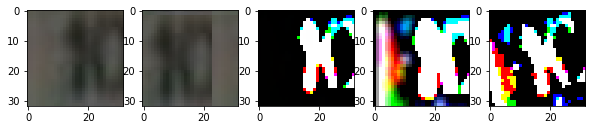

In [16]:
figure = plt.figure(figsize=(10,10))

test_image = X[:,:,:,np.random.randint(low=0,high=X.shape[-1])]

# original
plt.subplot(1,5,1)
plt.imshow(test_image)

#test shifting
plt.subplot(1,5,2)
plt.imshow(shift(test_image, maximum_shift_x=10,maximum_shift_y=10))

#test shifting
plt.subplot(1,5,3)
plt.imshow(np.uint16(znormalize(test_image)))

#test blur
plt.subplot(1,5,4)
plt.imshow((gaussian_blur((test_image),sigma=0.001,width=3)))


#test blur
plt.subplot(1,5,5)
plt.imshow(rotate(test_image,max_rotation_angle_degrees=45))

In [17]:
img_x, img_y, img_c = test_image.shape
print(img_x, img_y, img_c)


32 32 3


random angle was: [-17.86538729]


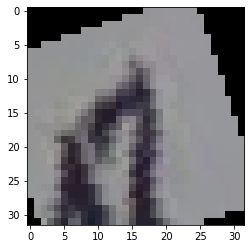

In [18]:
fig = plt.figure()
plt.imshow(np.int16(rotate(X[:,:,:,2020],max_rotation_angle_degrees=45, nearest_neighbour=True)))

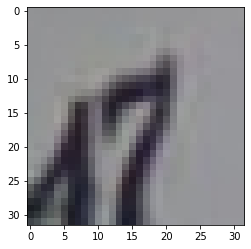

In [19]:
plt.imshow(X[:,:,:,2020])

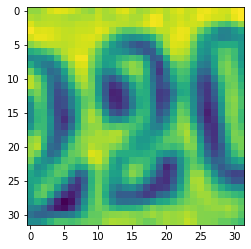

In [25]:
plt.imshow(grayscale(X[:,:,:,2222]))

In [28]:
augmentations = ['grayscale','rotate','gaussian_blur','shift']
augmentation_probability = 0.4
p_augs = np.random.rand(len(augmentations))
print(p_augs)
p_augs = p_augs <= augmentation_probability
print(p_augs)

[0.0106839  0.70104596 0.36712047 0.95852211]
[ True False  True False]


In [ ]:
augmentations={
    grayscale(X),
    rotate(X, max_rotation_angle_degrees=25),
    gaussian_blur(X, sigma=0.02, width=5),
    shift(X,maximum_shift_x)
}

In [41]:
def shift_redux(X, maximum_shift=(5,5), axis=(0,1)):
    """Randomly Shift the image up,down, left, or right"""
    # apply shift up-down-left-right with wrap-around
    # max shift is positive-and-negative
    # shift_x = np.random.randint(low=-maximum_shift_x, high=maximum_shift_x)
    # shift_y = np.random.randint(low=-maximum_shift_y, high=maximum_shift_y)

    # # L-R
    # output = np.roll(X, shift_x, axis=0)
    # # U-D
    # output = np.roll(output, shift_y, axis=1)
    assert len(maximum_shift)==len(axis)

    output = X
    for s, d in zip(maximum_shift,axis):
        output = np.roll(output,
                    shift = np.random.randint(low=-s, high=s),
                    axis = d)

    return output

19
-4


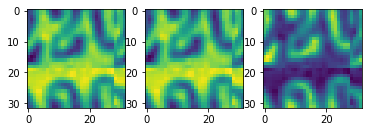

In [85]:
gray  = grayscale(X[:,:,:,2222])
figure=plt.figure()
gray_shifted = shift_redux(gray,maximum_shift=(20,5), axis=(0,1))
plt.subplot(1,3,1)
plt.imshow(gray_shifted)
plt.subplot(1,3,2)
plt.imshow(znormalize(gray_shifted))
plt.subplot(1,3,3)
plt.imshow(normalize(gray_shifted)-znormalize(gray_shifted))


0
4


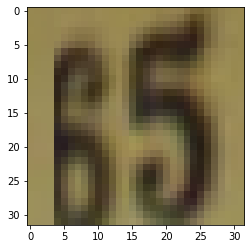

In [130]:
def createCompositeFunction(*funcs, probabilities):
    def apply(x):
        for func, probability in zip(funcs,probabilities):
            if np.random.random() <= probability:
                x = func(x)
        return x

    return apply


def f1(x, **kwargs):
    return x + 2


def f2(x):
    return x * 3


def f3(x):
    return x / 2

#comp = createCompositeFunction(f1, f2, f3)

transforms = createCompositeFunction(grayscale, shift_redux, znormalize, probabilities=[0,1,0.5])
t = transforms(X[:,:,:,1953])
plt.imshow(t)


In [117]:
test = np.ones(shape=(10,10,3,5))
scale = [0, 1, 1, 2, 3]

for ex in range(0, test.shape[-1]):
    test[...,ex]=(np.multiply(test[...,ex], scale[ex]))

test[...,4]
test.shape

(10, 10, 3, 5)

In [133]:
probability = 0.5
sigma = 0.1
M = np.ones(shape=(10,10,3))

noise = np.random.random(size=M.size)
noise = noise>probability
noise = noise*np.random.normal(loc=0,scale=sigma, size=M.size)

In [153]:
def noise(X, sigma=0.15, probability=0.5):
    """ Adds noise to image.
    max_size defines the max size (+/-) in proportion to the current pixel value.
    probability defines how likely the pixel is to get noise."""

    X += X * (np.random.random(size=X.shape) > probability) * np.random.normal(loc=0, size=X.shape)

In [156]:
test_image = X[:,:,:,np.random.randint(low=0,high=X.shape[-1])]
plt.imshow(noise(test_image))


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [158]:
test_image.shape[0:2]

(32, 32)

In [7]:
max(y)

array([10], dtype=uint8)

In [1]:
a = 2
axis = (2,3)
axis -= 1

TypeError: unsupported operand type(s) for -=: 'tuple' and 'int'

In [5]:
for a in range(len(axis)):
    axis[a] -=1

TypeError: 'tuple' object does not support item assignment

In [21]:
import numpy as np
A = np.ones(shape=(3,32,32,32))
axis = np.arange(0,A.ndim)
axis = axis[-2:]
maximum_shift = 100
maximum_shift = np.repeat(maximum_shift,len(axis))

In [22]:
print(axis, maximum_shift)

[2 3] [100 100]


In [25]:
A.shape[-2:]

(32, 32)